This notebook is aiming at organizing output from each step in multi-step strategy. It will process the output from first binary classifier first, then using the predicted "of_interest" records as input for second subgroup classifier. Then whichever records classified into either "lower_group" or "admit_group" will be used as inputs for third step classifier. This notebook finally convert the predicted results to Lexicon format.

Prerequisite:

1) csv file containing inference records

2) Each subsequent step is depending on the output from prior step. We need to download the output from Comprehend service and save it locally.


Output:

1) Predicted outputs saved in Lexicon format

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import boto3
import json
import re

##### Step 1: Binary Classification

In [4]:
# Assume test file is saved locally already, load the test file 
test_file_loc = "multistep-1-binary-testing-pure-content.csv"
test_df = pd.read_csv(test_file_loc, names=['content'])
test_df

content
0      PATIENT NAME : KING, EDWARD VLEXINGTON, KENTUC...
1      PATIENT NAME : KING, EDWARD VLEXINGTON, KENTUC...
2      HealthCareKING, EDWARD VUniversity of Kentucky...
3      DOS: 10/25/2018HealthCareKING, EDWARD VDOB: 04...
4      HealthCareKING, EDWARD VUniversity of Kentucky...
...                                                  ...
89384  Smith, Logan A2650 RIDGE AVENUEMRN: 216027151,...
89385  Smith, Logan A2650 RIDGE AVENUEMRN: 216027151,...
89386  Smith, Logan A2650 RIDGE AVENUEMRN: 216027151,...
89387  Smith, Logan A2650 RIDGE AVENUEMRN: 216027151,...
89388  Smith, Logan A2650 RIDGE AVENUEMRN: 216027151,...

[89389 rows x 1 columns]

In [3]:
# Load the test file with metainfo (filename, page number) as it will be used to reorganized the output 
test_df_metainfo = pd.read_csv('multistep-1-binary-testing-with-metainfo.csv')
test_df_metainfo

filename  page  \
0      1003700000000550247_11173976.pdf     1   
1      1003700000000550247_11173976.pdf     2   
2      1003700000000550247_11173976.pdf     3   
3      1003700000000550247_11173976.pdf     4   
4      1003700000000550247_11173976.pdf     5   
...                                 ...   ...   
89384  1003700000000697369_11103809.pdf   102   
89385  1003700000000697369_11103809.pdf   103   
89386  1003700000000697369_11103809.pdf   104   
89387  1003700000000697369_11103809.pdf   105   
89388  1003700000000697369_11103809.pdf   106   

                                                 content        class  \
0      PATIENT NAME : KING, EDWARD VLEXINGTON, KENTUC...       others   
1      PATIENT NAME : KING, EDWARD VLEXINGTON, KENTUC...       others   
2      HealthCareKING, EDWARD VUniversity of Kentucky...       others   
3      DOS: 10/25/2018HealthCareKING, EDWARD VDOB: 04...       others   
4      HealthCareKING, EDWARD VUniversity of Kentucky...       others   
...                                                  ...          ...   
89384  Smith, Logan A2650 RIDGE AVENUEMRN: 216027151,...       others   
89385  Smith, Logan A2650 RIDGE AVENUEMRN: 216027151,...       others   
89386  Smith, Logan A2650 RIDGE AVENUEMRN: 216027151,...       others   
89387  Smith, Logan A2650 RIDGE AVENUEMRN: 216027151,...  of_interest   
89388  Smith, Logan A2650 RIDGE AVENUEMRN: 216027151,...       others   

       filename_cut  
0               NaN  
1               NaN  
2               NaN  
3               NaN  
4               NaN  
...             ...  
89384           NaN  
89385           NaN  
89386           NaN  
89387      697369.0  
89388           NaN  

[89389 rows x 5 columns]

In [6]:
# Specify region and client
REGION = 'us-east-1'
s3 = boto3.resource('s3')
comprehend = boto3.client('comprehend', region_name = REGION)

Before kicking off the inference job in following step, first we need to visit lambda function "CompStartInferenceLambda" and change the corresponding model arn in Configuration -> Environment Variables to binary classifier's arn.

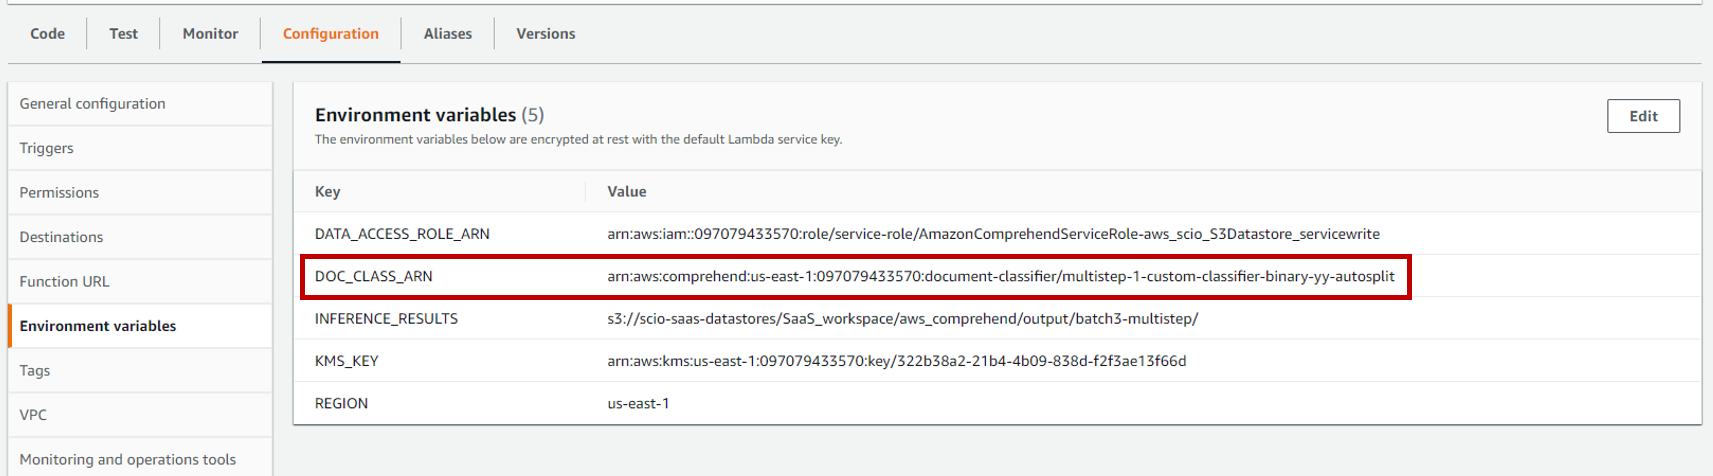

In [9]:
# upload testing file to S3, this folder is monitored by inference pipeline, so it will kick off inference job automatically
s3.Bucket('scio-test01').upload_file('multistep-1-binary-testing-pure-content.csv', 'SaaS_workspace/aws_comprehend/inputs/multistep-1-binary-testing-pure-content.csv')

The inference job will take several minutes to complete. Once it shows completed in the console, we can download the output and save the generated jsonl file locally.

In [10]:
# Filename of the comprehend output from first binary classifier
comprehend_output_file = 'predictions-multistep-1-binary.jsonl'

In [15]:
# Load Test data meta information
file_names = test_df_metainfo['filename'].to_list()
page_list = test_df_metainfo['page'].to_list()
content_list = test_df_metainfo['content'].to_list()

In [16]:
# Load Comprehend output result, save only prediction with confidence score higher than threshold to of_interest dataframe

of_interest_df = pd.DataFrame()
with open(comprehend_output_file, encoding = 'utf-8') as lines:
    for f,line, page, content in zip(file_names,lines, page_list, content_list):
        output_line = json.loads(line)
        
        for k, v in enumerate(output_line['Classes']):
            if v['Name'] == 'of_interest' and v['Score'] >= 0.4 :
                new_df = pd.DataFrame([{'file_name' : f, 'page' : page, 'content' : content}])
                of_interest_df = pd.concat([of_interest_df, new_df], axis=0, ignore_index=True)


##### Step 2: Subgroup Classification

In [19]:
# Check of_interest dataframe
of_interest_df

file_name  page  \
0      1003700000000550247_11173976.pdf    15   
1      1003700000000550247_11173976.pdf    16   
2      1003700000000550247_11173976.pdf    17   
3      1003700000000550247_11173976.pdf    18   
4      1003700000000550247_11173976.pdf    34   
...                                 ...   ...   
35425  1003700000000697369_11103809.pdf    55   
35426  1003700000000697369_11103809.pdf    56   
35427  1003700000000697369_11103809.pdf    57   
35428  1003700000000697369_11103809.pdf    61   
35429  1003700000000697369_11103809.pdf   105   

                                                 content  
0      HealthCareUniversity of Kentucky A.B. Chandler...  
1      Patient Name: Edward V. KingDOB:04/23/1957MRN:...  
2      Patient Name: Edward V. KingDOB:04/23/1957MRN:...  
3      .Patient Name: Edward V. KingDOB:04/23/1957MRN...  
4      UK Emar By Patient - HIMFormatCriteria for sel...  
...                                                  ...  
35425  Smith, Logan A2650 RIDGE AVENUEMRN: 216027151,...  
35426  Smith, Logan A2650 RIDGE AVENUEMRN: 216027151,...  
35427  Smith, Logan A2650 RIDGE AVENUEMRN: 216027151,...  
35428  Smith, Logan A2650 RIDGE AVENUEMRN: 216027151,...  
35429  Smith, Logan A2650 RIDGE AVENUEMRN: 216027151,...  

[35430 rows x 3 columns]

In [18]:
# Save of_interest dataframe with and without metainfo to local
of_interest_df.to_csv("multistep-2-of-interest-testing-with-metainfo.csv", index=False)
of_interest_df['content'].to_csv("multistep-2-of-interest-testing-pure-content.csv", index=False, header=False)

of_interest dataframe's "content" column will be used as the input data for second subgroup classifier

Before kicking off the inference job in following step, similar to prior case, we need to visit lambda function "CompStartInferenceLambda" and change the corresponding model arn in Configuration -> Environment Variables to subgroup classifier's arn.

In [20]:
# upload testing file to S3, this folder is monitored by inference pipeline, so it will kick off inference job automatically
s3.Bucket('scio-test01').upload_file('multistep-2-of-interest-testing-pure-content.csv', 'SaaS_workspace/aws_comprehend/inputs/multistep-2-of-interest-testing-pure-content.csv')

Inference will take several minutes to complete. Once it shows complete, download the predicted jsonl file to locally

In [21]:
# Load Test data meta information
file_names = of_interest_df['file_name'].to_list()
page_list = of_interest_df['page'].to_list()
content_list = of_interest_df['content'].to_list()

In [22]:
# Filename of the comprehend output from second subgroup classifier
comprehend_output_file = "predictions_multistep_2_subgroup.jsonl"

In [23]:
# Load Comprehend output result, save only prediction with confidence score higher than threshold. 

# Predictions_list is the list to save every predicted results (no grouping class, just 17 classes)
predictions_list = []
# Admit group dataframe is the dataframe to save input records for admit_group classifier
admit_group_df = pd.DataFrame()
# Lower group dataframe is the dataframe to save input records for lower_group classifier
lower_group_df = pd.DataFrame()

with open(comprehend_output_file, encoding = 'utf-8') as lines:
    for f,line, page, content in zip(file_names,lines, page_list, content_list):
        output_line = json.loads(line)
        
        for k, v in enumerate(output_line['Labels']):
            if v['Score'] > 0.3:
                if v['Name'] == 'admit_group':
                    new_df = pd.DataFrame([{'file_name' : f, 'page' : page, 'content' : content}])
                    admit_group_df = pd.concat([admit_group_df, new_df], axis=0, ignore_index=True)
                elif v['Name'] == 'lower_group':
                    new_df = pd.DataFrame([{'file_name' : f, 'page' : page, 'content' : content}])
                    lower_group_df = pd.concat([lower_group_df, new_df], axis=0, ignore_index=True)
                else:
                    output_dict = {'page' : page, 'FileName' : f, 'class' : v['Name']}
                    predictions_list.append(output_dict)
        

##### Step 3a: Admit Group Classification

In [25]:
# Check admit_group_df
admit_group_df

file_name  page  \
0     1003700000000550247_11173976.pdf    62   
1     1003700000000550247_11173976.pdf    88   
2     1003700000000550247_11173976.pdf   104   
3     1003700000000550247_11173976.pdf   107   
4     1003700000000550247_11173976.pdf   110   
...                                ...   ...   
1786  1003700000000743289_11240275.pdf     5   
1787  1003700000000743289_11240275.pdf     6   
1788  1003700000000697369_11103809.pdf     2   
1789  1003700000000697369_11103809.pdf     3   
1790  1003700000000697369_11103809.pdf   105   

                                                content  
0     Documents Review ReportPatient: KING, EDWARD V...  
1     016425100UKHealthCarePatient:KING, EDWARD VAge...  
2     Complete SCM Orders Summary (Clinical View by ...  
3     Complete SCM Orders Summary (Clinical View by ...  
4     Complete SCM Orders Summary (Clinical View by ...  
...                                                 ...  
1786  ReadingTime TakenCommentsBlood Pressure8036/06...  
1787  Attending Provider: Corwin J Rankin, MDAttendi...  
1788  Smith, Logan A2650 RIDGE AVENUEMRN: 216027151,...  
1789  Smith, Logan A2650 RIDGE AVENUEMRN: 216027151,...  
1790  Smith, Logan A2650 RIDGE AVENUEMRN: 216027151,...  

[1791 rows x 3 columns]

In [26]:
# Save admit_group dataframe with and without metainfo to local
admit_group_df.to_csv("multistep-3-admit-group-with-metainfo.csv", index=False)
admit_group_df['content'].to_csv("multistep-3-admit-group-testing-pure-content.csv", index=False, header=False)

admit_group dataframe's "content" column will be used as the input data for third admit_group classifier

Before kicking off the inference job in following step, similar to prior case, we need to visit lambda function "CompStartInferenceLambda" and change the corresponding model arn in Configuration -> Environment Variables to admit_group classifier's arn.

In [35]:
# upload testing file to S3, this folder is monitored by inference pipeline, so it will kick off inference job automatically
s3.Bucket('scio-test01').upload_file('multistep-3-admit-group-testing-pure-content.csv', 'SaaS_workspace/aws_comprehend/inputs/multistep-3-admit-group-testing-pure-content.csv')

Inference will take several minutes to complete. Once it shows complete, download the predicted jsonl file to locally

In [39]:
# Load Test data meta information
file_names = admit_group_df['file_name'].to_list()
page_list = admit_group_df['page'].to_list()
content_list = admit_group_df['content'].to_list()

In [40]:
# Specify output from Comprehend
comprehend_output_file = 'predictions-multistep3-admit-group.jsonl'

In [41]:
# Load Comprehend output result, save only prediction with confidence score higher than threshold 

with open(comprehend_output_file, encoding = 'utf-8') as lines:
    for f,line, page, content in zip(file_names,lines, page_list, content_list):
        output_line = json.loads(line)
        
        for k, v in enumerate(output_line['Labels']):
            
            if v['Score'] > 0.3:

                output_dict = {'page' : page, 'FileName' : f, 'class' : v['Name']}
                predictions_list.append(output_dict)
                

##### Step 3b: Lower Group Classification

In [28]:
# Check lower_group dataframe
lower_group_df

file_name  page  \
0    1003700000000550247_11173976.pdf    69   
1    1003700000000550247_11173976.pdf    70   
2    1003700000000550247_11173976.pdf    71   
3    1003700000000550247_11173976.pdf    72   
4    1003700000000550607_11237679.pdf    14   
..                                ...   ...   
559  1003700000000740568_11238289.pdf    33   
560  1003700000000742786_11238442.pdf    61   
561  1003700000000742786_11238442.pdf    66   
562  1003700000000742786_11238442.pdf    81   
563  1003700000000697369_11103809.pdf    13   

                                               content  
0    Documents Review ReportxPatient: KING, EDWARD ...  
1    Documents Review ReportPatient: KING, EDWARD V...  
2    Documents Review ReportPatient: KING, EDWARD V...  
3    Documents Review ReportxPatient:KING, EDWARD V...  
4    pulmonary ventilation, and response to care we...  
..                                                 ...  
559  Performed AtConsent: Informed consent for the ...  
560  DATE OF SERVICE: 06/02/2021PROCEDURE:Debrideme...  
561  Dear Doctor,Please continue to document the ap...  
562  Description:Outcome: ProgressingElectronically...  
563  Smith, Logan A2650 RIDGE AVENUEMRN: 216027151,...  

[564 rows x 3 columns]

In [29]:
# Save lower_group dataframe with and without metainfo to local
lower_group_df.to_csv("multistep-3-lower-group-with-metainfo.csv", index=False)
lower_group_df['content'].to_csv("multistep-3-lower-group-testing-pure-content.csv", index=False, header=False)

lower_group dataframe's "content" column will be used as the input data for third lower_group classifier

Before kicking off the inference job in following step, similar to prior case, we need to visit lambda function "CompStartInferenceLambda" and change the corresponding model arn in Configuration -> Environment Variables to lower_group classifier's arn.

In [30]:
# upload testing file to S3
s3.Bucket('scio-test01').upload_file('multistep-3-lower-group-testing-pure-content.csv', 'SaaS_workspace/aws_comprehend/inputs/multistep-3-lower-group-testing-pure-content.csv')

Inference will take several minutes to complete. Once it shows complete, download the predicted jsonl file to locally

In [36]:
# Load Test data meta information
file_names = lower_group_df['file_name'].to_list()
page_list = lower_group_df['page'].to_list()
content_list = lower_group_df['content'].to_list()

In [37]:
# Specify output from Comprehend
comprehend_output_file = 'predictions-multistep3-lower-group.jsonl'

In [38]:
# Load Comprehend output result, save only prediction with confidence score higher than threshold 

with open(comprehend_output_file, encoding = 'utf-8') as lines:
    for f,line, page, content in zip(file_names,lines, page_list, content_list):
        output_line = json.loads(line)
        
        for k, v in enumerate(output_line['Labels']):
            if v['Score'] > 0.3:

                output_dict = {'page' : page, 'FileName' : f, 'class' : v['Name']}
                predictions_list.append(output_dict)


##### Step 4: Convert Output to Lexicon Format

All the outputs have been saved into predictions_list, we need to convert it ready in Lexicon format

In [42]:
# Convert outputs to Lexicon format
seen_list =  []
output_file = []
output_dict = {}
total_dict = {}


for f in predictions_list:
    
    if f['FileName'] not in seen_list:
        seen_list.append(f['FileName'])
    
        total_dict[f['FileName']] = {'FileName' :'' ,'Results' : {}}

        
    output_class = f['class']
    total_dict[f['FileName']]['FileName'] = f['FileName']

    if f['class'] in total_dict[f['FileName']]['Results']:
        total_dict[f['FileName']]['Results'][output_class]['classification_pages'] = total_dict[f['FileName']]['Results'][output_class]['classification_pages'] + ',' + str(f['page'])

    else:

        if f['class'] != 'others' :
            total_dict[f['FileName']]['Results'].update({output_class: {'classification_pages' : str(f['page'])}})


In [43]:
# Save Lexicon format outputs to a folder
directory_name = "batch3_multistep"
for f_name in total_dict.keys():
    output_dict = total_dict[f_name]
    with open(f"{directory_name}/{re.sub('.pdf','',f_name)}.json", 'w') as f:
        json.dump(output_dict,f)